In [1]:
import sys
sys.path.append('./scripts')
import numpy as np
from matplotlib import pyplot as plt
import pymanopt

import sys
sys.path.append('../')
from scripts import flag_dimensionality_reduction as fdr

import pandas as pd


In [2]:
def inliers_outliers_features_manifold(manifold, inlier_dim: int, n_in: int = 100, n_out: int = 20, seed: int = 123, show_plots: bool = False) -> list:


    np.random.seed(seed)

    n_pts = n_in + n_out

    center = manifold.random_point()

    n = manifold.random_tangent_vector(center).shape[0]

    t_data = np.zeros((n_pts,n))

    t_data = .01*np.random.randn(n_pts, n)

    t_data[n_in:, inlier_dim:] = .1*np.random.randn(n_out, n-inlier_dim)

    
    if show_plots:
        plt.figure()
        plt.scatter(t_data[:n_in, 0], t_data[:n_in, 1])
        plt.scatter(t_data[n_in:, 0], t_data[n_in:, 1])


    data = []
    for i in range(n_pts):
        data.append(manifold.exp(center, t_data[i,:]))
    
    return data

In [3]:

rand_seed = 420
n_inliers = 100
n_outliers= 20
total_dim = 5
inlier_dim = 2
n_trials = 50

df = pd.DataFrame(columns = ['Algorithm', 'Mean', 'StDev'])

manifold = pymanopt.manifolds.sphere.Sphere(total_dim)
data = inliers_outliers_features_manifold(manifold, inlier_dim, n_inliers, n_outliers, seed = rand_seed)

outs = []
for seed in range(n_trials):
    out= fdr.flag_robust_tpca(manifold, data, pca_type = 'wpca', fl_type = [1,2], rand_seed = seed, return_all = True, init = 'rand')
    outs.append(out)


errs = []
for o in outs:
    errs.append(o[1])


max_len = max(len(lst) for lst in errs)
for i, lst in enumerate(errs):
    if len(lst) < max_len:
        errs[i] += [np.nan] * (max_len - len(lst))

# Calculate mean and standard deviation for each row
mean_values = np.mean(errs, axis=0)
std_dev = np.std(errs, axis=0)

row = pd.DataFrame(columns = df.columns,
                   data= [['L1WPCA', mean_values, std_dev]])
df = pd.concat([df, row])

# Create an array of x values (e.g., row indices)
x_values = np.arange(len(errs[1]))


outs = []
for seed in range(n_trials):
    out= fdr.flag_robust_tpca(manifold, data, pca_type = 'rpca', fl_type = [1,2], rand_seed = seed, return_all = True, init = 'rand')
    outs.append(out)


errs = []
for o in outs:
    errs.append(o[1])


max_len = max(len(lst) for lst in errs)
for i, lst in enumerate(errs):
    if len(lst) < max_len:
        errs[i] += [np.nan] * (max_len - len(lst))

# Calculate mean and standard deviation for each row
mean_values = np.mean(errs, axis=0)
std_dev = np.std(errs, axis=0)

row = pd.DataFrame(columns = df.columns,
                   data= [['L1RPCA', mean_values, std_dev]])
df = pd.concat([df, row])

# Create an array of x values (e.g., row indices)
x_values = np.arange(len(errs[1]))


outs = []
for seed in range(n_trials):
    out= fdr.flag_robust_tpca(manifold, data, pca_type = 'dpcp', fl_type = [1,2], rand_seed = seed, return_all = True, init = 'rand')
    outs.append(out)

errs = []
for o in outs:
    errs.append(o[1])


max_len = max(len(lst) for lst in errs)
for i, lst in enumerate(errs):
    if len(lst) < max_len:
        errs[i] += [np.nan] * (max_len - len(lst))

# Calculate mean and standard deviation for each row
mean_values = np.mean(errs, axis=0)
std_dev = np.std(errs, axis=0)

row = pd.DataFrame(columns = df.columns,
                   data= [['L1DPCP', mean_values, std_dev]])
df = pd.concat([df, row])

# Create an array of x values (e.g., row indices)
x_values = np.arange(len(errs[1]))







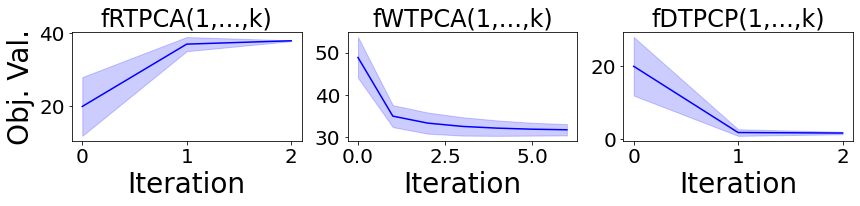

In [8]:
plt.rcParams.update({'font.size': 20})
 
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = (14,2))

for ax, alg, lbl in zip([ax1, ax2, ax3], ['L1RPCA', 'L1WPCA', 'L1DPCP'], ['fRTPCA(1,...,k)', 'fWTPCA(1,...,k)', 'fDTPCP(1,...,k)']):
    
    mean_values = df[df['Algorithm'] == alg]['Mean'].values[0]
    std_dev = df[df['Algorithm'] == alg]['StDev'].values[0]
    x_values = np.arange(len(mean_values))

    # Plot the mean values with fill_between
    ax.fill_between(x_values, mean_values - std_dev, mean_values + std_dev, alpha=0.2, color='b')

    # Plot the mean values
    ax.plot(x_values, mean_values, color='b')
    ax.set_title(lbl)

    # Customize the plot (optional)
    ax.set_xlabel('Iteration')
ax1.set_ylabel('Obj. Val.')

plt.savefig('../Results/all_convergence.pdf', bbox_inches='tight')